In [1]:
import os
from concurrent.futures import as_completed, ThreadPoolExecutor

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import fft
from sklearn.model_selection import train_test_split


def to_gray(image):
    # Convert the input image to grayscale
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


def load_img_with_features(filepath):
    # Read the image from the specified file path
    img = cv2.imread(filepath)
    # Convert the image to grayscale
    gray_img = to_gray(img)
    # Compute the absolute value of the 2D FFT of the grayscale image and flatten the result
    features = np.abs(fft.fft2(gray_img)).flatten()
    # Return the first FFT coefficient (DC component), the rest of the coefficients, and all features
    return features[0], features[1:], features


def load_imgs_from_directory(directory, num_images=None):
    # Initialize lists to store DC values, DC dash values, and features
    dc_val = []
    dc_dash_val = []
    features_1 = []
    # Get the list of all files in the specified directory
    files = os.listdir(directory)
    # Limit the number of files to the specified number if provided
    if num_images is not None:
        files = files[:num_images]
    # Use ThreadPoolExecutor to process images concurrently
    with ThreadPoolExecutor() as executor:
        # Submit tasks to executor for loading images and extracting features
        futures = [executor.submit(load_img_with_features, os.path.join(directory, filename)) for filename in files]
        # Process each future as it completes
        for future in as_completed(futures):
            dc, dc_dash, features = future.result()
            features_1.append(features)
            dc_val.append(dc)
            dc_dash_val.append(dc_dash)
    # Return lists of DC values, DC dash values, and extracted features
    return dc_val, dc_dash_val, features_1


# Define directories for fake and real images
fake_dir = "E:\\College\\5th Sem\\ML\\Lab\\train\\FAKE"
real_dir = "E:\\College\\5th Sem\\ML\\Lab\\train\\REAL"


In [2]:
# Set the number of images to load from each directory
num_images_to_load = 10000

# Load images from the fake directory and extract DC values, DC dash values, and features
DC_vals_train, DC_dash_train, features_fake = load_imgs_from_directory(fake_dir, num_images=num_images_to_load)

# Load images from the real directory and extract DC values, DC dash values, and features
DC_vals_test, DC_dash_test, features_real = load_imgs_from_directory(real_dir, num_images=num_images_to_load)

# print(len(DC_dash_test))
# print(len(DC_dash_train))
# print(len(DC_vals_test))
# print(len(DC_vals_train))

# Concatenate DC values from both the test and train datasets
dc_val = np.concatenate((DC_vals_test, DC_vals_train))

# Stack DC dash values vertically from both datasets
dc_dash = np.vstack((DC_dash_test, DC_dash_train))

# Stack feature arrays vertically from both the fake and real datasets
features = np.vstack((features_fake, features_real))

# print(len(dc_dash))
# print(len(dc_val))


In [3]:
# Split the dataset into training and testing sets
# `dc_dash` is the feature matrix, `dc_val` is the target variable
# `test_size=0.5` means 50% of the data will be used for testing
# `random_state=32` ensures the split is reproducible
X_train, X_test, y_train, y_test = train_test_split(dc_dash, dc_val, test_size=0.5, random_state=32)


In [4]:
from sklearn.linear_model import LinearRegression

In [5]:
# Create and train a Linear Regression model using the training data
reg = LinearRegression().fit(X_train, y_train)

# Predict the target values (DC values) for the test dataset using the trained model
y_train_pred = reg.predict(X_test)


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [7]:
print(y_train_pred)
print(y_train)

[122228.70310533  92980.70310533 113556.70310533 ... 111988.70310533
 129972.70310533 124276.70310533]
[120036. 109349. 108313. ... 128765. 107447. 115445.]


In [8]:
# Calculate Mean Squared Error (MSE) between actual and predicted values on the test data
mse_train = mean_squared_error(y_train, y_train_pred)

# Calculate Root Mean Squared Error (RMSE) on the test data
rmse_train = np.sqrt(mse_train)

# Calculate Mean Absolute Percentage Error (MAPE) between actual and predicted values on the test data
mape_train = mean_absolute_percentage_error(y_train, y_train_pred)

# Calculate R^2 Score (coefficient of determination) to evaluate the goodness of fit
r2_train = r2_score(y_train, y_train_pred)

# Print evaluation metrics for the model's performance on the training data
print(f"Mean Squared Error (MSE) on training data:\t{mse_train}")
print(f"Root Mean Squared Error (RMSE) on training data:\t{rmse_train}")
print(f"Mean Absolute Percentage Error (MAPE) on training data:\t{mape_train}")
print(f"R^2 Score on training data:\t{r2_train}")


Mean Squared Error (MSE) on training data:	882055113.2541723
Root Mean Squared Error (RMSE) on training data:	29699.412675239426
Mean Absolute Percentage Error (MAPE) on training data:	0.20935582199945157
R^2 Score on training data:	-0.1358188359462622


In [9]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

In [10]:
# Perform KMeans clustering on the feature set
# `n_clusters=2` indicates the number of clusters to form (in this case, 2)
# `random_state=0` ensures reproducibility of results
# `n_init="auto"` automatically determines the number of initializations for clustering
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(features)

# Print the labels assigned to each sample (indicating the cluster each sample belongs to)
print(kmeans.labels_)

# Print the coordinates of the cluster centers
print(kmeans.cluster_centers_)

# Compute the Calinski-Harabasz score to evaluate the clustering quality
# The higher the score, the better-defined the clusters are
calinski_harabasz_score(features, kmeans.labels_)


[0 1 0 ... 0 1 1]
[[101663.29714235   9971.97295818   5270.39250083 ...   2809.02480181
    3996.98661801   6821.22746178]
 [144914.35707689  10115.02619139   5292.95889505 ...   2748.12844775
    4014.61243079   6949.87767169]]


7863.661765396808

In [11]:
def kmeans_wrapper(n_clusters, X):
    # Perform KMeans clustering on the dataset X with the specified number of clusters
    # `n_clusters` defines the number of clusters to form
    # `random_state=32` ensures the clustering results are reproducible
    kmeans = KMeans(n_clusters=n_clusters, random_state=32).fit(X)
    
    # Print the cluster labels assigned to each data point
    print(kmeans.labels_)
    
    # Return a dictionary containing:
    # - "labels": The cluster labels for each data point
    # - "centres": The coordinates of the cluster centers
    # - "inertia": The sum of squared distances of samples to their closest cluster center
    return {
        "labels": kmeans.labels_,
        "centres": kmeans.cluster_centers_,
        "inertia": kmeans.inertia_,
    }


In [18]:
def get_scores(X, start, end):
    # Initialize a dictionary to store clustering scores and distortions for different numbers of clusters
    results = {
        "Davies-Bouldin Score": [],    # To store Davies-Bouldin scores
        "Silhouette Score": [],        # To store Silhouette scores
        "Calinski-Harabasz Score": [], # To store Calinski-Harabasz scores
        "distortions": [],             # To store inertia (within-cluster sum of squares)
        "K": list(range(start, end))   # Range of cluster numbers to evaluate
    }
    
    # Loop over the range of cluster numbers
    for i in range(start, end):
        # Get the clustering results for the current number of clusters
        labels, centres, inertia = kmeans_wrapper(i, X).values()
        n_labels = len(set(labels))  # Number of unique clusters

        # Calculate the scores only if more than one cluster is formed
        if n_labels > 1:
            # Append the Calinski-Harabasz score for current clustering
            results["Calinski-Harabasz Score"].append(calinski_harabasz_score(X, labels))
            
            # Append the Silhouette score for current clustering
            results["Silhouette Score"].append(silhouette_score(X, labels))
            
            # Append the Davies-Bouldin score for current clustering
            results["Davies-Bouldin Score"].append(davies_bouldin_score(X, labels))
        
        # Append the distortion (inertia) for current clustering
        results["distortions"].append(inertia)
    
    # Return the dictionary containing all scores and distortions
    return results


In [19]:
features

array([[106979.        ,   3892.20315557,   3644.34430744, ...,
          4524.1444969 ,   5072.40688809,   8376.08616131],
       [124959.        ,  14672.1972386 ,   2922.10747745, ...,
          2922.89157649,   9377.08965318,  11504.5739285 ],
       [ 85520.        ,  10736.78322302,   6645.63780205, ...,
           543.61670117,   4305.37428453,   3961.60418154],
       ...,
       [ 77181.        ,   2870.65557877,   3171.85725784, ...,
          1823.95496442,   6630.43065552,  12190.31032044],
       [167738.        ,   8304.27830827,   3693.27266513, ...,
          5250.026441  ,   4124.60159029,   3390.18982707],
       [145783.        ,  10534.6195036 ,   3075.74426642, ...,
          1253.72821632,   3000.51901321,   6429.66485748]])

In [20]:
results_df = pd.DataFrame(get_scores(features, 2, 25))

[0 1 0 ... 0 1 1]
[2 0 2 ... 2 1 1]
[2 0 2 ... 2 1 0]
[2 0 2 ... 2 1 4]
[0 1 0 ... 2 5 4]
[3 1 3 ... 2 5 6]
[0 1 4 ... 2 5 6]
[4 7 4 ... 2 5 8]
[2 7 2 ... 9 0 8]
[ 4  3  4 ...  9  5 10]
[ 0  1  4 ...  9  7 10]
[ 4  1  4 ...  9  5 10]
[ 0  3  4 ...  9  7 10]
[ 4  3  4 ... 11  5 10]
[ 4  3  4 ... 11  5 10]
[16  3 16 ... 11  5 10]
[16  3  2 ... 11  5 10]
[16  1  2 ... 11  5 10]
[16  1 16 ... 11  5 10]
[ 3  7 20 ... 13 12 17]
[ 3  7 20 ... 13 12 17]
[ 1  7 20 ... 13 12 17]
[ 1  7 20 ... 13  9 14]


In [15]:
import seaborn as sns

In [21]:
results_df

,Davies-Bouldin Score,Silhouette Score,Calinski-Harabasz Score,distortions,K
0,1.524170,0.232122,7863.660642,2.380523e+13,2
1,1.783593,0.160861,5859.163327,2.091166e+13,3
2,1.944974,0.148676,4751.012144,1.936366e+13,4
3,1.885886,0.145133,4159.947306,1.810175e+13,5
4,1.983501,0.124892,3670.427052,1.729302e+13,6
5,1.931492,0.109915,3359.919038,1.651422e+13,7
6,1.983999,0.105142,3053.939047,1.602758e+13,8
7,2.005762,0.090546,2817.639887,1.558871e+13,9
8,2.030079,0.087317,2608.895798,1.525160e+13,10
9,2.055199,0.087282,2432.702025,1.495971e+13,11


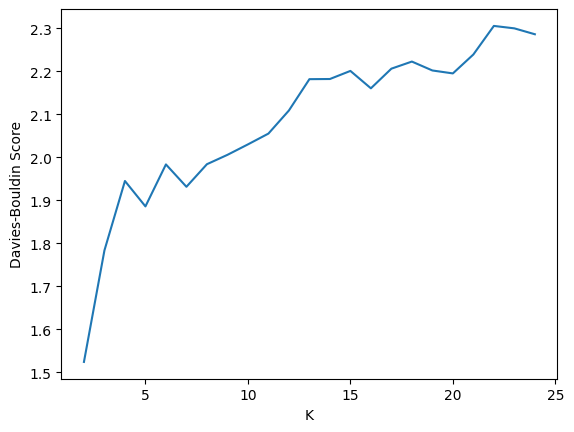

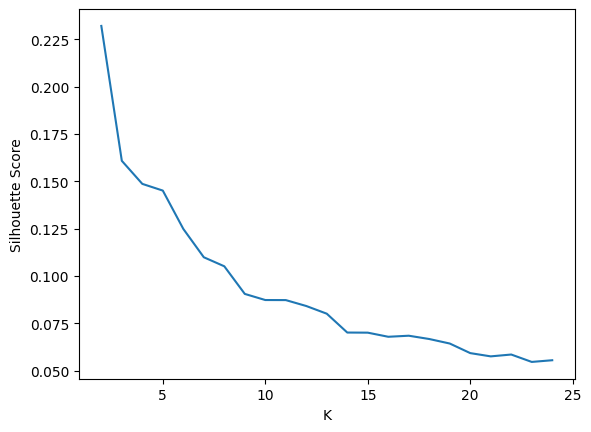

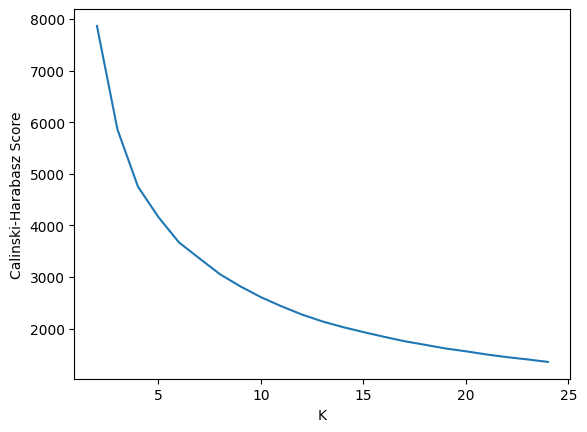

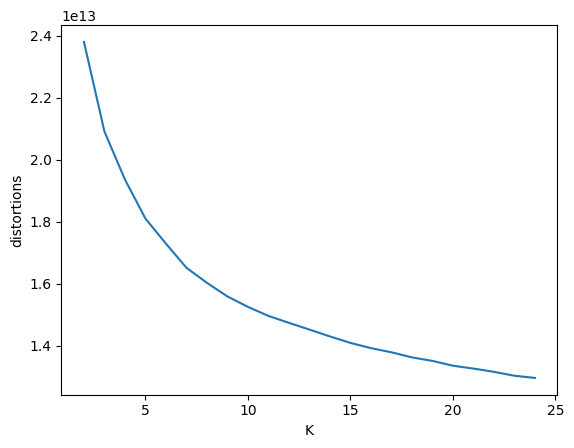

In [27]:
sns.lineplot(data = results_df, x="K", y="Davies-Bouldin Score")
plt.show()
sns.lineplot(data=results_df, x="K", y="Silhouette Score")
plt.show()
sns.lineplot(data=results_df, x="K", y="Calinski-Harabasz Score")
plt.show()
sns.lineplot(data=results_df, x="K", y="distortions")
plt.show()